<a href="https://colab.research.google.com/github/apachon/python-machine-learning-book-3rd-edition/blob/master/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [6]:
v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

0.0

Reading-in the Iris data



In [7]:
import os
import pandas as pd


s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)

df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')

df.tail()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Plotting the Iris data

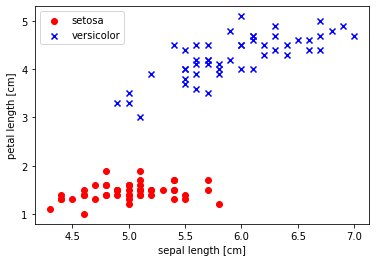

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

Training the perceptron model

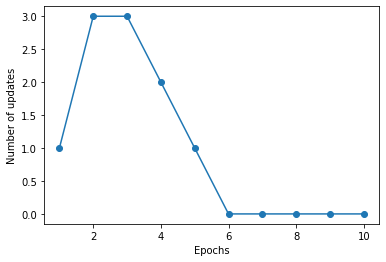

In [9]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

A function for plotting decision regions

In [0]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

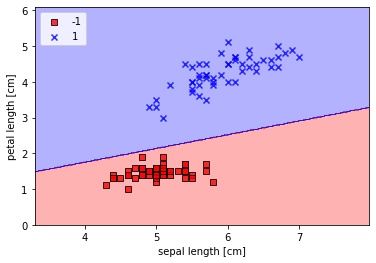

In [11]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_08.png', dpi=300)
plt.show()

Implementing an adaptive linear neuron in Python

In [0]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

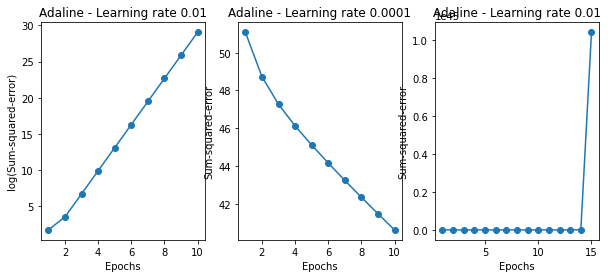

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

ada3 = AdalineGD(n_iter=15, eta=0.01).fit(X, y)
ax[2].plot(range(1, len(ada3.cost_) + 1), ada3.cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Sum-squared-error')
ax[2].set_title('Adaline - Learning rate 0.01')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

Improving gradient descent through feature scaling

In [0]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

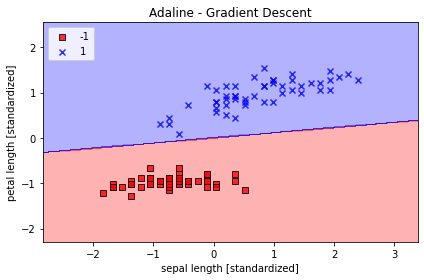

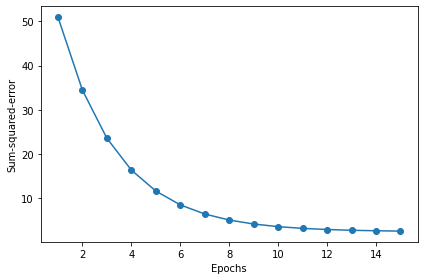

In [23]:
ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/02_14_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('images/02_14_2.png', dpi=300)
plt.show()

Large scale machine learning and stochastic gradient descent

In [0]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

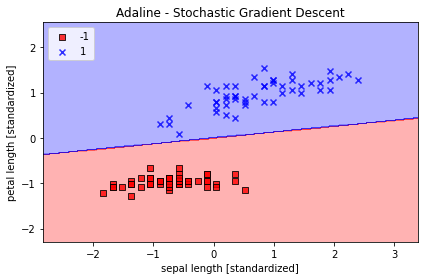

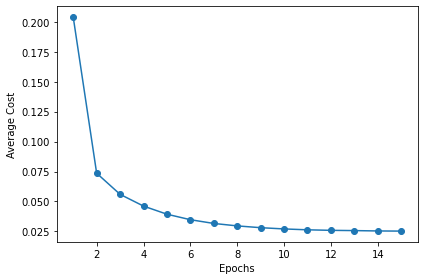

In [25]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('images/02_15_2.png', dpi=300)
plt.show()

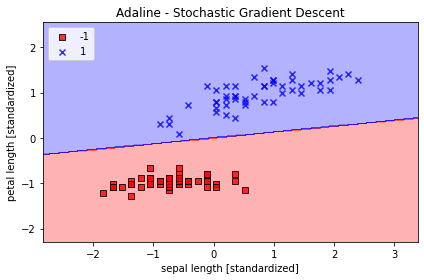

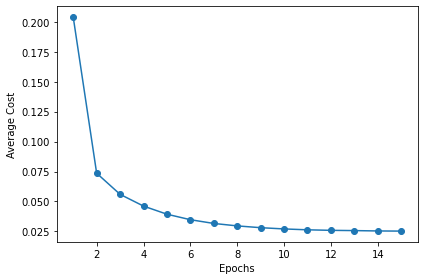

In [27]:
ada_sgd.partial_fit(X_std[0, :], y[0])